### Import Libraries

In [28]:
# %% [markdown]
# ### Import Libraries

# %%
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,
    Dropout, Add, Activation, Multiply, BatchNormalization, UpSampling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import keras_tuner as kt

# Set random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


### Load and Data Preprocessing 

In [29]:
def load_images(image_dir, mask_dir, image_size=(128, 128)):
    images, masks = [], []
    for filename in sorted(os.listdir(image_dir)):
        if not filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):
            continue
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)  # assumes same name pattern

        if not os.path.exists(mask_path):
            print(f"Mask missing for: {filename}")
            continue

        img = load_img(img_path, color_mode='grayscale', target_size=image_size)
        mask = load_img(mask_path, color_mode='grayscale', target_size=image_size)

        images.append(img_to_array(img) / 255.0)
        masks.append(img_to_array(mask) / 255.0)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)
    if masks.ndim == 3:
        masks = np.expand_dims(masks, axis=-1)
    return images, masks


base_path = "Train_Dataset_Generated"
image_dir = os.path.join(base_path, 'img')
mask_dir = os.path.join(base_path, 'mask')

images, masks = load_images(image_dir, mask_dir)
print(f"Loaded {len(images)} images and {len(masks)} masks.")

Loaded 160 images and 160 masks.


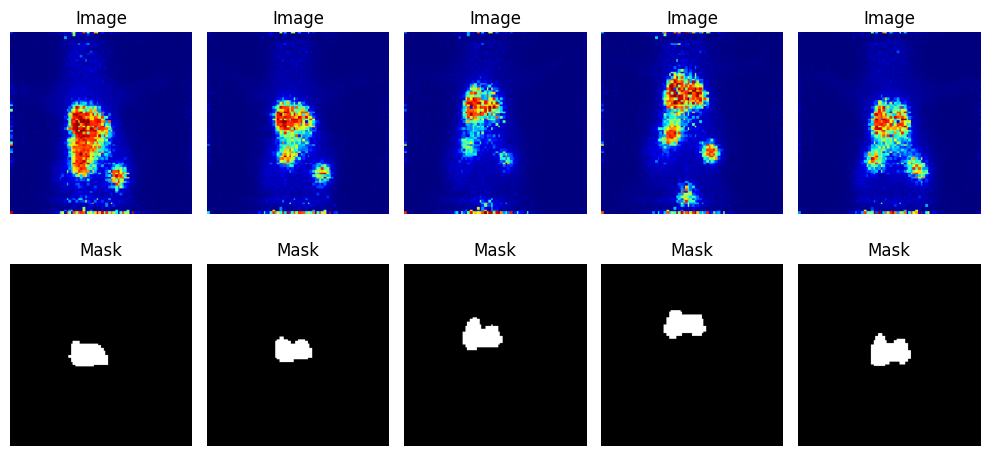

In [30]:
# Visualize some images and masks
def visualize_samples(images, masks, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        if i >= len(images):
            break
        # Display image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[6*i].squeeze(), cmap='jet')
        plt.axis('off')
        plt.title("Image")
        
        # Display mask
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(masks[6*i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Mask")
    
    plt.tight_layout()
    plt.show()

visualize_samples(images, masks)

### Split Train/Test


In [31]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    images, masks, test_size=0.2
)
print("Training:", X_train.shape, "Testing:", X_test.shape)

Training: (128, 128, 128, 1) Testing: (32, 128, 128, 1)


### Define Attention-U-Net Builder

In [25]:
# -----------------------------------------
# Recurrent Block (NO residual)
# -----------------------------------------
def recurrent_block(x, filters, t=2):
    """Simple recurrent convolution block."""
    x1 = x
    for _ in range(t):
        x1 = Conv2D(filters, 3, padding='same')(x1)
        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)
    return x1


In [26]:
def build_rec_unet_tuner(hp):

    filters = hp.Choice("filters", [16, 32, 64])
    t = hp.Choice("t", [1, 2, 3])
    lr = hp.Choice("lr", [1e-4, 5e-4, 1e-3])

    inputs = Input((128, 128, 1))

    # Encoder
    c1 = recurrent_block(inputs, filters, t); p1 = MaxPooling2D(2)(c1)
    c2 = recurrent_block(p1, filters*2, t); p2 = MaxPooling2D(2)(c2)
    c3 = recurrent_block(p2, filters*4, t); p3 = MaxPooling2D(2)(c3)
    c4 = recurrent_block(p3, filters*8, t); p4 = MaxPooling2D(2)(c4)

    bn = recurrent_block(p4, filters*16, t)

    # Decoder
    u4 = Conv2DTranspose(filters*8, 2, strides=2, padding="same")(bn)
    u4 = concatenate([u4, c4])
    c5 = recurrent_block(u4, filters*8, t)

    u3 = Conv2DTranspose(filters*4, 2, strides=2, padding="same")(c5)
    u3 = concatenate([u3, c3])
    c6 = recurrent_block(u3, filters*4, t)

    u2 = Conv2DTranspose(filters*2, 2, strides=2, padding="same")(c6)
    u2 = concatenate([u2, c2])
    c7 = recurrent_block(u2, filters*2, t)

    u1 = Conv2DTranspose(filters, 2, strides=2, padding="same")(c7)
    u1 = concatenate([u1, c1])
    c8 = recurrent_block(u1, filters, t)

    outputs = Conv2D(1, 1, activation="sigmoid")(c8)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


### Hyperparameter Tuning

In [27]:
tuner = kt.GridSearch(
    build_rec_unet_tuner,   # <-- correct builder
    objective="val_loss",
    max_trials=5,
    directory="rec_unet_tuner_dir",
    project_name="rec_unet_gridsearch",
)


tuner.search_space_summary()

tuner.search(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
    ]
)

tuner.results_summary()


Reloading Tuner from rec_unet_tuner_dir\rec_unet_gridsearch\tuner0.json
Search space summary
Default search space size: 3
filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
t (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
lr (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.0005, 0.001], 'ordered': True}
Results summary
Results in rec_unet_tuner_dir\rec_unet_gridsearch
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
filters: 16
t: 2
lr: 0.0005
Score: 0.06678268313407898

Trial 2 summary
Hyperparameters:
filters: 16
t: 1
lr: 0.001
Score: 0.11192505806684494

Trial 1 summary
Hyperparameters:
filters: 16
t: 1
lr: 0.0005
Score: 0.1260194480419159

Trial 0 summary
Hyperparameters:
filters: 16
t: 1
lr: 0.0001
Score: 0.2276497185230255

Trial 3 summary
Hyperparameters:
filters: 16
t: 2
lr: 0.0001
Score: 0.43242233991622925


In [12]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"""
Best Hyperparameters:
num_filters = {best_hps.get('filters')}
dropout_rate = {best_hps.get('t')}
learning_rate = {best_hps.get('lr')}
""")


Best Hyperparameters:
num_filters = 16
dropout_rate = 2
learning_rate = 0.0005



In [17]:
model = build_rec_unet_tuner(best_hps)
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=4,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 390ms/step - accuracy: 0.8697 - loss: 0.5651 - val_accuracy: 0.9731 - val_loss: 0.6326
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - accuracy: 0.9835 - loss: 0.3549 - val_accuracy: 0.9732 - val_loss: 0.5174
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.9910 - loss: 0.3036 - val_accuracy: 0.9732 - val_loss: 0.4331
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.9929 - loss: 0.2721 - val_accuracy: 0.9732 - val_loss: 0.3696
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9944 - loss: 0.2442 - val_accuracy: 0.9732 - val_loss: 0.3528
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.9952 - loss: 0.2202 - val_accuracy: 0.9732 - val_loss: 0.3362
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.9953 - loss: 0.1994 - val_accuracy: 0.9732 - val_loss: 0.3120
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.9956 - loss: 0.1798 - val_accuracy

In [18]:
model.save('model_3_RUnet.h5')

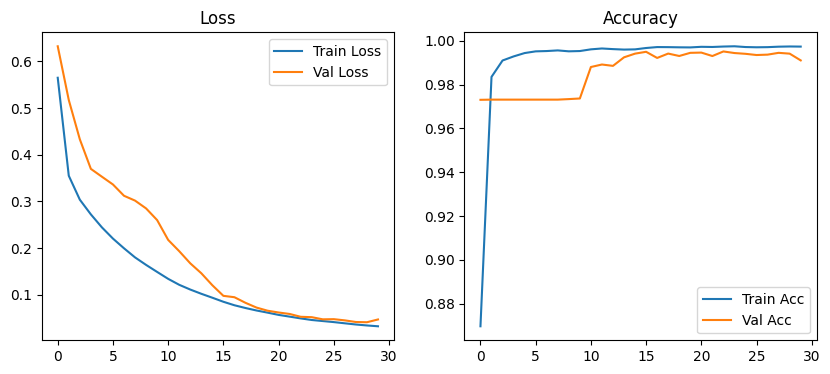

In [19]:
# -------------------------------
# Plot Training Curves
# -------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()


In [32]:
from tensorflow.keras.models import load_model

model = load_model('z_models/model_3_RUnet.h5', compile=False)


In [33]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

preds_test = model.predict(X_test)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

dice_scores = []
precisions = []
recalls = []
accuracies = []

TP_total = 0
TN_total = 0
FP_total = 0
FN_total = 0

for i in range(len(X_test)):
    y_true = y_test[i].squeeze()
    y_pred = preds_test_t[i].squeeze()
    
    # Flatten for sklearn metrics
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    dice_scores.append(dice_coef(y_true, y_pred))
    precisions.append(precision_score(y_true_flat, y_pred_flat))
    recalls.append(recall_score(y_true_flat, y_pred_flat))
    accuracies.append(accuracy_score(y_true_flat, y_pred_flat))
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat, labels=[0,1]).ravel()
    TP_total += tp
    TN_total += tn
    FP_total += fp
    FN_total += fn

print(f"Average Dice Coefficient: {np.mean(dice_scores):.3f}")
print(f"Average Precision: {np.mean(precisions):.3f}")
print(f"Average Recall: {np.mean(recalls):.3f}")
print(f"Average Accuracy: {np.mean(accuracies):.3f}")

print("\nTotal Confusion Matrix:")
print(f"TP: {TP_total}, TN: {TN_total}, FP: {FP_total}, FN: {FN_total}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Average Dice Coefficient: 0.922
Average Precision: 0.938
Average Recall: 0.912
Average Accuracy: 0.996

Total Confusion Matrix:
TP: 12487, TN: 509775, FP: 841, FN: 1185


In [8]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

preds_test = model.predict(X_test)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

dice_scores = []
precisions = []
recalls = []
accuracies = []

TP_total = 0
TN_total = 0
FP_total = 0
FN_total = 0

for i in range(len(X_test)):
    y_true = y_test[i].squeeze()
    y_pred = preds_test_t[i].squeeze()
    
    # Flatten for sklearn metrics
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    dice_scores.append(dice_coef(y_true, y_pred))
    precisions.append(precision_score(y_true_flat, y_pred_flat))
    recalls.append(recall_score(y_true_flat, y_pred_flat))
    accuracies.append(accuracy_score(y_true_flat, y_pred_flat))
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat, labels=[0,1]).ravel()
    TP_total += tp
    TN_total += tn
    FP_total += fp
    FN_total += fn

print(f"Average Dice Coefficient: {np.mean(dice_scores):.3f}")
print(f"Average Precision: {np.mean(precisions):.3f}")
print(f"Average Recall: {np.mean(recalls):.3f}")
print(f"Average Accuracy: {np.mean(accuracies):.3f}")

print("\nTotal Confusion Matrix:")
print(f"TP: {TP_total}, TN: {TN_total}, FP: {FP_total}, FN: {FN_total}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 822ms/step
Average Dice Coefficient: 0.890
Average Precision: 0.920
Average Recall: 0.879
Average Accuracy: 0.994

Total Confusion Matrix:
TP: 13104, TN: 540701, FP: 1410, FN: 1841


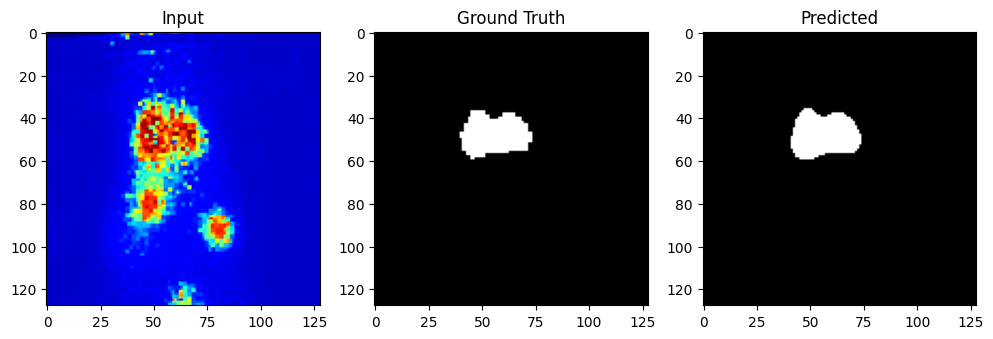

In [35]:
# -------------------------------
# Visualize a Random Prediction
# -------------------------------
import random
ix = random.randint(0, len(X_test) - 1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(X_test[ix].squeeze(), cmap='jet'); plt.title('Input')
plt.subplot(1,3,2); plt.imshow(y_test[ix].squeeze(), cmap='gray'); plt.title('Ground Truth')
plt.subplot(1,3,3); plt.imshow(preds_test_t[ix].squeeze(), cmap='gray'); plt.title('Predicted')
plt.show()